In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, VGG16
from keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np
import keras_tuner as kt
import pandas as pd
from PIL import Image
import cv2 as cv
import pillow_heif
from deepface import DeepFace
import os
#import tensorflow_datasets as tfds



In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def batch_heic_to_png(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".heic"):
            input_path = os.path.join(input_folder, filename)
            output_filename = os.path.splitext(filename)[0] + ".jpg"
            output_path = os.path.join(output_folder, output_filename)
            
            try:
                # Open HEIC image and save as PNG
                heif_image = pillow_heif.open_heif(input_path)
                image = Image.frombytes(
                    heif_image.mode, 
                    heif_image.size, 
                    heif_image.data
                )
                image = image.resize((224,224))
                image = image.convert("L")
                image.save(output_path, format="JPEG", quality = 100)
                #print(f"Converted: {input_path} -> {output_path}")
            except Exception as e:
                print(f"Failed to convert {input_path}: {e}")

In [4]:
input_folder_happy = './Image Processing Dataset/Happy'
input_folder_sad = './Image Processing Dataset/Sad'

In [5]:
output_folder_happy = './Image Processing Dataset/Converted_Images/faces/Happy'
output_folder_sad = './Image Processing Dataset/Converted_Images/faces/Sad'

In [6]:
batch_heic_to_png(input_folder_happy, output_folder_happy)
batch_heic_to_png(input_folder_sad, output_folder_sad)

In [7]:
# Define the directory containing your images
input_dir_happy2 = './Image Processing Dataset/Happy2'
input_dir_sad2 = './Image Processing Dataset/Sad2'
# Create the output directory if it doesn't exist
def img_preprocessing(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # Open an image file
            with Image.open(os.path.join(input_dir, filename)) as img:
                # Resize image to 224x224
                img = img.resize((224, 224), Image.LANCZOS)
                # Convert image to greyscale
                img = img.convert('L')
                # Save the processed image
                img.save(os.path.join(output_dir, filename))

print("All images have been processed and saved.")

All images have been processed and saved.


In [8]:
img_preprocessing(input_dir_happy2, output_folder_happy)
img_preprocessing(input_dir_sad2, output_folder_sad)

In [9]:
training_path = './Image Processing Dataset/Converted_Images/faces'

In [10]:
classes=[]
paths=[]
images=[]
for dirname, _, filenames in os.walk(training_path):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            class_name=(dirname.split('\\')[-1])
            file_path=os.path.join(dirname, filename)
            paths.append(file_path)
            classes.append(class_name)
#            try:
#                # Detect and align face
#                face = DeepFace.extract_faces(file_path, detector_backend="mtcnn",enforce_detection=False)
#                images.append(face)
#                
#            except Exception as e:
#                print(f"Error processing {file_path}: {e}")

In [11]:
print(len(classes))


15117


In [12]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

df=pd.DataFrame(columns=['path','class','label'])
df['path']=paths
df['class']=classes
df['label']=df['class'].map(normal_mapping)
print(len(df))

['Happy', 'Sad']
15117


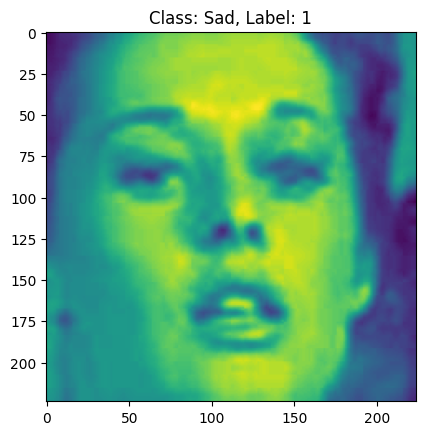

In [13]:
#register_heif_opener()
image_no = 15000
image_path = df['path'].iloc[image_no]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Class: {df['class'].iloc[image_no]}, Label: {df['label'].iloc[image_no]}")
plt.axis('on')  # Hide axes
plt.show()

In [14]:
testing_path = './Image Processing Dataset/Converted_Images/faces'

In [15]:
print('number of samples: ', len(df['class']))
print('keys: ', list(df.keys()))
print('image shape: ', df.shape)
print('labels:', np.unique(df['class']))

number of samples:  15117
keys:  ['path', 'class', 'label']
image shape:  (15117, 3)
labels: ['Happy' 'Sad']


In [16]:
batch_size = 32
img_size = (224,224)
validation_split = 0.2

In [17]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=validation_split,
    labels='inferred',
    subset="training",
    seed=123,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size
)

Found 15117 files belonging to 2 classes.
Using 12094 files for training.


In [18]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=validation_split,
    labels='inferred',
    subset="validation",
    shuffle=True,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 15117 files belonging to 2 classes.
Using 3023 files for validation.


In [19]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [20]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 48
Number of test batches: 47


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
def preprocess_dataset(dataset):
    def one_hot_encode(image, label):
        label = tf.cast(label, tf.int32)
        label = tf.one_hot(label, depth=2)
        return image, label
    return dataset.map(one_hot_encode)

train_ds = preprocess_dataset(train_dataset)
val_ds = preprocess_dataset(validation_dataset)
test_ds = preprocess_dataset(test_dataset)

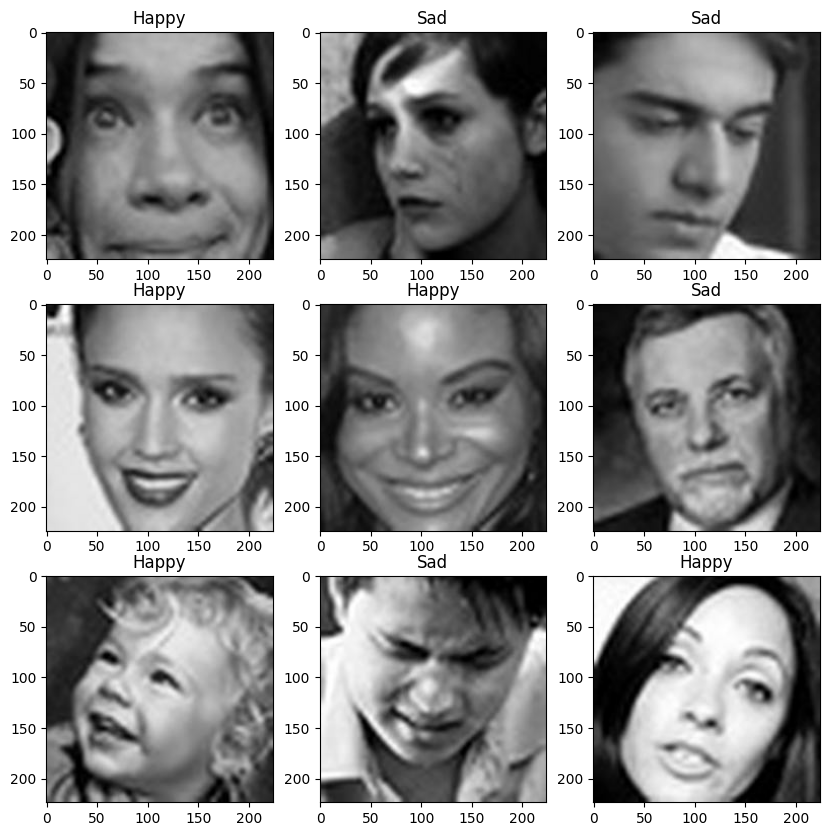

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])

In [24]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(224,224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [25]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [26]:
#image_batch, label_batch = next(iter(train_dataset))
# Resize the images to match the expected input shape of the base_model
#image_batch = tf.image.resize(image_batch, (img_size[0], img_size[1]))
#image_batch = tf.image.resize(image_batch, (224, 224))
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
def model_tuner(hp):
    my_model = models.Sequential([
                                data_augmentation,

                                base_model,

                                layers.GlobalAveragePooling2D(),

                                Dense(hp.Int('Dense_1', min_value=128, max_value=512, step=128), activation='relu'),

                                BatchNormalization(),
                                
                                Dropout(hp.Float('Dropout_1', min_value=0.2,max_value=0.6,step=0.1)),

                                #Dense(hp.Int('Dense_2', min_value=128, max_value=512, step=128), activation='relu'),

                                #Dropout(hp.Float('Dropout_2',min_value=0.2,max_value=0.5,step=0.1)),

                                layers.Dense(2, activation='softmax')])
    my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return my_model


In [29]:
tuner = kt.Hyperband(
    model_tuner,
    objective='val_accuracy',
    max_epochs=25,
    factor=3,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Reloading Tuner from hyperparam_tuning\cnn_tuning\tuner0.json


In [30]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [31]:
best_model = tuner.hypermodel.build(best_hps)

In [32]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)              

In [33]:
loss0, accuracy0 = best_model.evaluate(train_ds)

378/378 [==============================] - 27s 58ms/step - loss: 0.7901 - accuracy: 0.5960


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.60


In [35]:
history = best_model.fit(train_ds,
                    epochs=50,
                    batch_size=32,
                    validation_data=val_ds,
                    callbacks=[early_stopping])


Epoch 1/50
378/378 [==============================] - 90s 220ms/step - loss: 0.7076 - accuracy: 0.6776 - val_loss: 0.4421 - val_accuracy: 0.8038
Epoch 2/50
378/378 [==============================] - 83s 218ms/step - loss: 0.5462 - accuracy: 0.7562 - val_loss: 0.3917 - val_accuracy: 0.8354
Epoch 3/50
378/378 [==============================] - 82s 218ms/step - loss: 0.4877 - accuracy: 0.7842 - val_loss: 0.3734 - val_accuracy: 0.8473
Epoch 4/50
378/378 [==============================] - 82s 216ms/step - loss: 0.4568 - accuracy: 0.7963 - val_loss: 0.4402 - val_accuracy: 0.8117
Epoch 5/50
378/378 [==============================] - 81s 214ms/step - loss: 0.4370 - accuracy: 0.8048 - val_loss: 0.3622 - val_accuracy: 0.8466
Epoch 6/50
378/378 [==============================] - 81s 215ms/step - loss: 0.4221 - accuracy: 0.8093 - val_loss: 0.3447 - val_accuracy: 0.8624
Epoch 7/50
378/378 [==============================] - 81s 215ms/step - loss: 0.4234 - accuracy: 0.8113 - val_loss: 0.3647 - val_ac

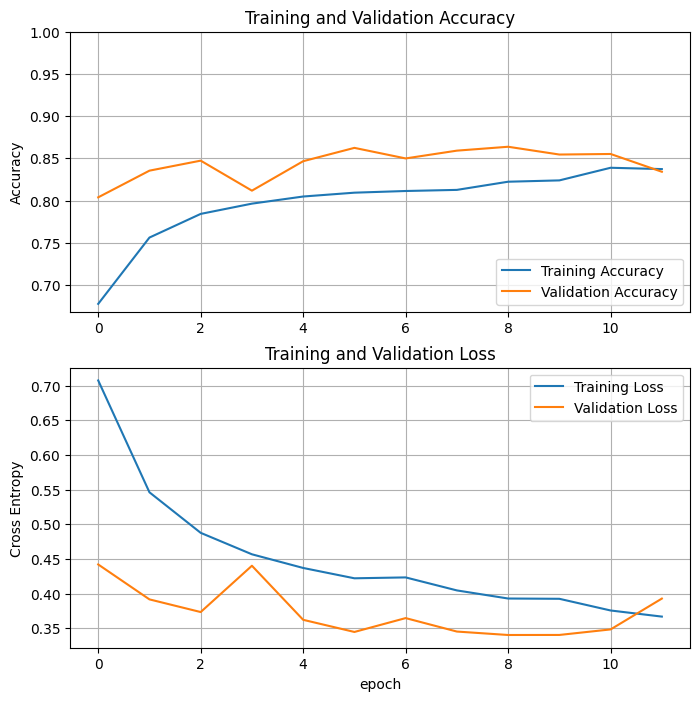

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [37]:

loss, accuracy = best_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

47/47 [==============================] - 3s 59ms/step - loss: 0.3395 - accuracy: 0.8524
Test accuracy : 0.852393627166748


Predictions:
 [1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0]
Labels:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


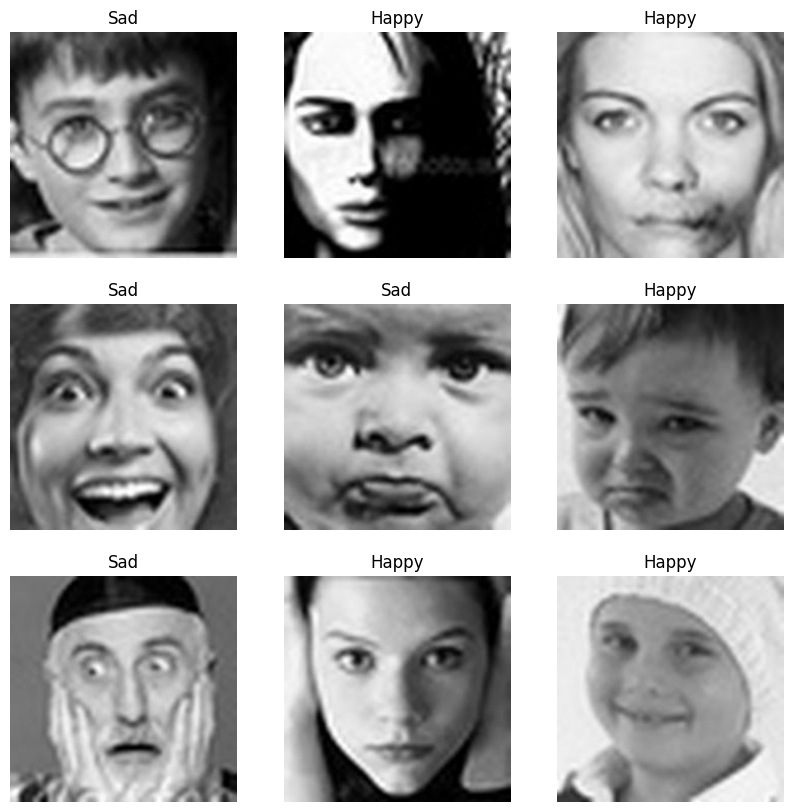

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Classification Report:
              precision    recall  f1-score   support

       Happy       0.87      0.88      0.88       891
         Sad       0.83      0.80      0.81       613

    accuracy                           0.85      1504
   macro avg       0.85      0.84      0.85      1504
weighted avg       0.85      0.85      0.85      1504



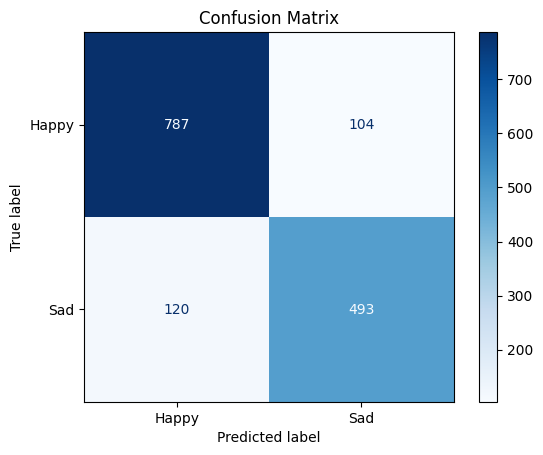

Accuracy: 0.85


In [45]:
val_labels = []
val_predictions = []

# Collect predictions and true labels
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    val_labels.extend(np.argmax(labels.numpy(), axis=1))
    val_predictions.extend(np.argmax(preds, axis=1))

val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Generate classification report
print("Classification Report:")

print(classification_report(val_labels, val_predictions, target_names=['Happy', 'Sad']))

# Generate confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Happy', 'Sad'])
disp.plot(cmap='Blues', values_format='d')  # Improved visuals
plt.title(f"Confusion Matrix")
plt.show()

# Calculate and display accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")